# check how the data is structured for fugw

In [143]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

base_dir = os.path.abspath('..')
sys.path.append(base_dir)

from graph_matching.data_loader.graph_loader import NetworkLoader
from graph_matching.data_loader.graph_loader import compute_mean_network

atlas = 'Schaefer1000'
structure_type='ses-01'
loader = NetworkLoader(atlas, structure_type, base_dir=base_dir+'/data_new_struct')

_, network = next(loader)

atlas_coord = loader.atlas_coordinates
#atlas_coord = atlas_coord.transpose()

network = network.astype(float)

In [144]:
mean_network = compute_mean_network(loader)

In [146]:
### Normalize
atlas_coord_normalized = atlas_coord / np.linalg.norm(
    atlas_coord, axis=0
)
network_normalized = network / np.max(network)
mean_network_normalized = mean_network / np.max(mean_network)

In [148]:
atlas_coord_normalized.shape

(1000, 3)

In [149]:
from fugw.mappings import FUGW
alpha = 1
rho = 1
eps = 1e-4
mapping = FUGW(alpha=alpha, rho=rho, eps=eps)

In [150]:
_, network = next(loader)

In [151]:
_ = mapping.fit(
    atlas_coord_normalized.transpose(),
    atlas_coord_normalized.transpose(),
    source_geometry=network_normalized,
    target_geometry=mean_network_normalized,
    solver="mm",
    solver_params={
        "nits_bcd": 5,
        "tol_bcd": 1e-10,
        "tol_uot": 1e-10,
    },
    verbose=False,
)

/opt/anaconda3/envs/graph_matching/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install "ipywidgets"
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [155]:
pi = mapping.pi.numpy()

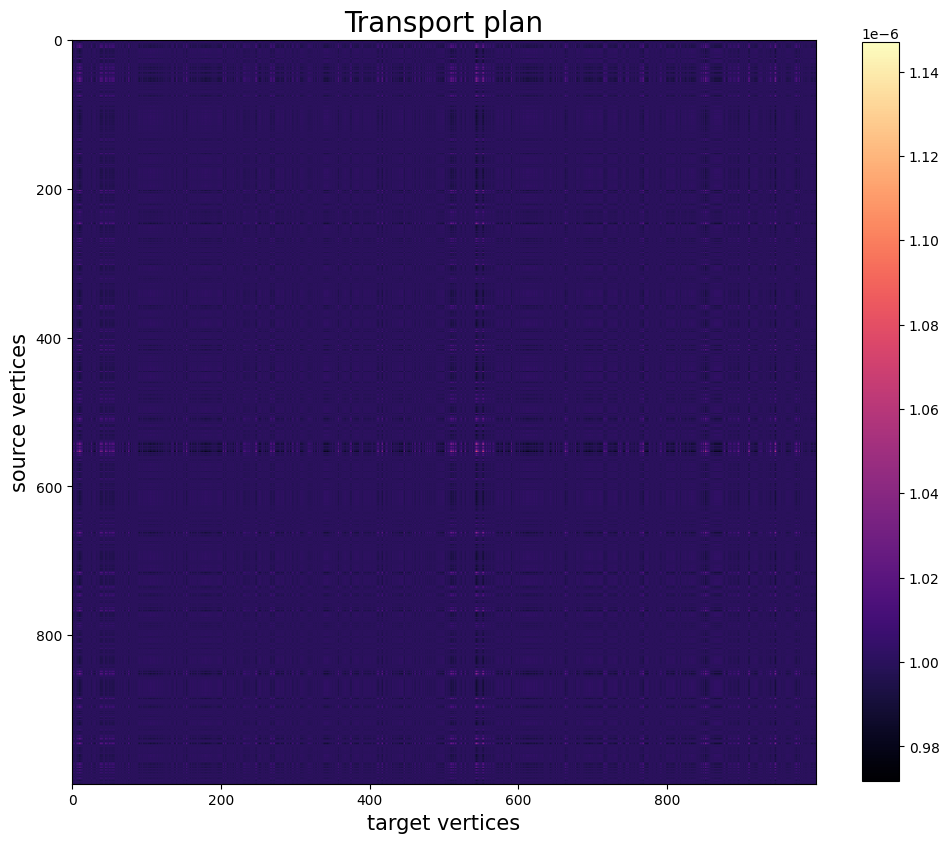

In [156]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_title("Transport plan", fontsize=20)
ax.set_xlabel("target vertices", fontsize=15)
ax.set_ylabel("source vertices", fontsize=15)
#im = plt.imshow(np.log(pi), cmap="magma")
im = plt.imshow(pi, cmap="magma")
plt.colorbar(im, ax=ax, shrink=0.8)
plt.show()

In [157]:
# Convert the double stochastic matrix to permutation matrix
from scipy.optimize import linear_sum_assignment
_, col = linear_sum_assignment(pi, maximize=True)

In [158]:
(col == np.arange(col.shape[0])).all()

False

In [163]:
def double_stochastic_array_to_permuation(double_stoch_array):
    """ 
    Function for finding the permutation matrix closest to given
    double stochastic matrix.

    Only returns one half of the permutation. The other half is the 
    identity and can be calculated using np.arange(col.shape[0])
    """
    _, col = linear_sum_assignment(double_stoch_array, maximize=True)
    return col

def compute_displacements(atlas_coord, node_permutations: list):
    """
    Computes the distances that each atlas node is permuted by
    a series of permutations.

    INPUT:
        - atlas_coord (np.array)  num subject X 3 array with
            coordinates of each node in the atlas
        - node_permutations (list[np.array()]): list of arrays, each array
            contains the permutation found for a single person

    OUT:
        - numpy array with the distances of how far away each node
            was permutted for each person
    """
    return np.concatenate(
                [
                    np.linalg.norm(atlas_coord - atlas_coord[node_permutation, :], axis=1)
                    for node_permutation in node_permutations 
                ]
            )

permutation = double_stochastic_array_to_permuation(pi)

displacement = compute_displacements(
    atlas_coord=atlas_coord,
    node_permutations=[permutation, permutation]
    )

displacements = {'fugw': displacement}

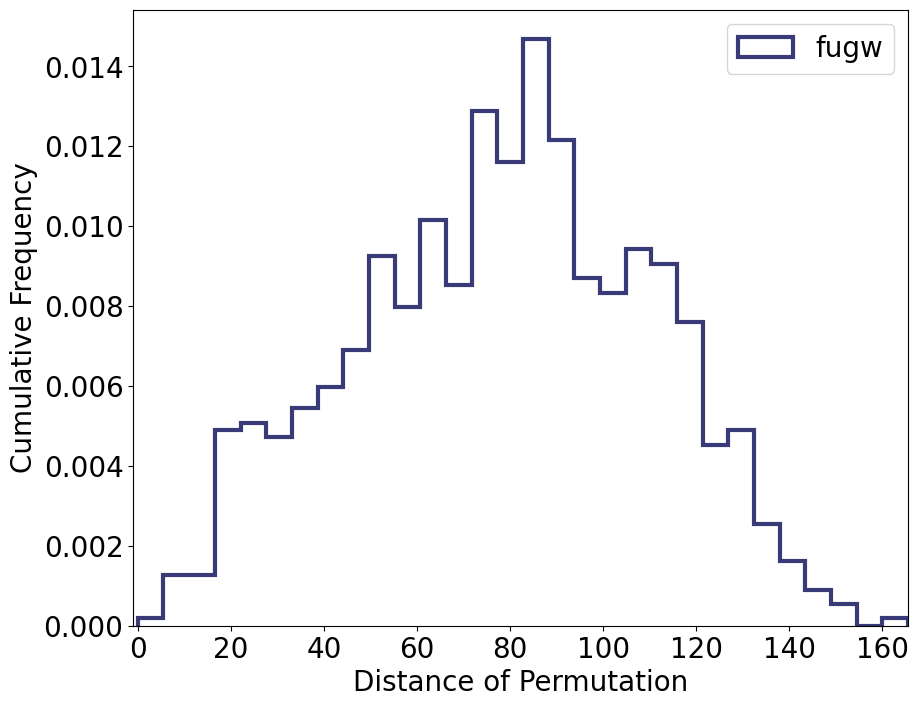

In [168]:
def plot_displacement_hist(displacements, n_bins=100, cumulative=True, density=True, nbins=30):

    fig, ax = plt.subplots(figsize=(10, 8))

    colors = plt.get_cmap('tab20b').colors

    xmax = 0
    for i, (model_name, distances) in enumerate(displacements.items()):
        ax.hist(
            distances,
            label=model_name,
            bins=nbins,
            histtype='step',
            color=colors[i],
            cumulative=cumulative,
            density=density,
            linewidth=3,
            )
        xmax = np.max([np.max(distances), xmax])

    ax.set_xlim([-1, xmax])
    ax.set_xlabel('Distance of Permutation', fontsize=20)
    ax.set_ylabel('Cumulative Frequency', fontsize=20)

    plt.legend(fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)

    return fig, ax
fig, ax = plot_displacement_hist(displacements, cumulative=False) 